# ELEC70126 - Internet of Things and Applications - Module Exam

### Import the required libraries

In [1282]:
import os
import requests
import msal
import os, json
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import numpy as np
from statsmodels.tsa.stattools import adfuller
import re
from textblob import TextBlob
from wordcloud import WordCloud
import gspread
from google.oauth2.service_account import Credentials

### Reading data from microsoft Azure

In [1283]:
# Read the weather data from OneDrive and download the JSON files (Replace your credintials here) 
client_id = ''
client_secret = ''
tenant_id = '2b897507-ee8c-4575-830b-4f8267c3d307'
authority = f'https://login.microsoftonline.com/{tenant_id}'
scope = ['https://graph.microsoft.com/.default']
onedrive_folder_id = '%2Fpersonal%2Faaa1624%5Fic%5Fac%5Fuk%2FDocuments%2FIoT%5Fdata' 
download_path = '/Users/Downloads/Downloaded_json'  

# Create a confidential client application
app = msal.ConfidentialClientApplication(client_id, authority=authority, client_credential=client_secret)

# Acquire a token
result = app.acquire_token_for_client(scopes=scope)
if 'access_token' in result:
    access_token = result['access_token']
    headers = {'Authorization': f'Bearer {access_token}'}
    
    # Get the list of files in the OneDrive folder
    url = f'https://graph.microsoft.com/v1.0/me/drive/items/{onedrive_folder_id}/children'
    
    response = requests.get(url, headers=headers)
    files = response.json().get('value', [])
    
    # Download each file
    for file in files:
        file_id = file['id']
        file_name = file['name']
        download_url = f'https://graph.microsoft.com/v1.0/me/drive/items/{file_id}/content'
        
        # Download the file
        file_response = requests.get(download_url, headers=headers)
        
        if file_response.status_code == 200:
            with open(os.path.join(download_path, file_name), 'wb') as f:
                f.write(file_response.content)
            print(f'Downloaded {file_name}')
        else:
            print(f'Failed to download {file_name}')
else:
    print('Failed to acquire token')


### Local Data Loading

In [ ]:
# Local path to the weather JSON file
path_to_json = '/Data/Raw/weather/'
columns2 = ['temp', 'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity', 'sea_level', 'grnd_level','wind_speed','date','time']

def json_processing(json_path = path_to_json, required_columns=columns2):
    # Create a DataFrame to store the data
    df = pd.DataFrame(columns = required_columns)
    json_files = [pos_json for pos_json in os.listdir(json_path) if pos_json.endswith('.json')]

    # loop through the rows in the json file
    for index, js in enumerate(json_files):
        with open(os.path.join(path_to_json, js)) as json_file:
            json_text = json.load(json_file)
            date = js.title().split("_")[1].split(".")[0].split(" ")[0].split('-')[:3]
            time = js.title().split("_")[1].split(".")[0].split(" ")[0].split('-')[3:5]
            time = ':'.join(time)
            date = '-'.join(reversed(date))
            values = list(json_text['body']['main'].values())
            wind = float(list(json_text['body']['wind'].values())[0])
            values.append(wind)
            values.append(date)
            values.append(time)
            df.loc[len(df)] = values
    return df

df_weather = json_processing()

In [ ]:
# reading and storing the energy consumption data
water = '/Data/Raw/thames_water.csv'
power = '/Data/Raw/ovo_power.csv'
heat = '/Data/Raw/dataenergy_heat.csv'


df_water = pd.read_csv(water)
df_power = pd.read_csv(power)
df_heat = pd.read_csv(heat)

### Data pre-processing

In [1286]:
# Add cost variables to energy dataframes
cost_per_m3 = 1.9145
df_water['total_cost'] = df_water['Consumption Cubic meter'] * cost_per_m3

cost_per_kwh = 0.09029
df_heat['total_cost'] = df_heat['Consumption'] * cost_per_kwh

df_power['Cost'] = df_power['Cost'].str.replace('£', '').astype(float)
df_power['Consumption'] = df_power['Consumption'].str.replace('kWh', '').astype(float)
df_power.rename(columns={'Cost':'total_cost'}, inplace=True)
df_water.rename(columns={'Consumption Cubic meter':'consumption_water'}, inplace=True)
df_water.rename(columns={'Consumption in Litres':'consumption_l'}, inplace=True)
df_heat.rename(columns={'Consumption':'heat_consumption'}, inplace=True)
df_power.rename(columns={'Consumption':'power_consumption'}, inplace=True)

In [1287]:
# Convert date columns to datetime
df_weather['datetime'] = pd.to_datetime(df_weather['date'].astype(str) + ' ' + df_weather['time'].astype(str), format='%d-%m-%Y %H:%M')
df_weather['date'] = pd.to_datetime(df_weather['date'], format='%d-%m-%Y')
df_water['date'] = pd.to_datetime(df_water['Date'], format='%d-%m-%y')
df_power['date'] = pd.to_datetime(df_power['Date'], format='%d-%m-%y')
df_heat['date'] = pd.to_datetime(df_heat['Read Date'], format='%d-%m-%y')

### Data Exploration (Time-series)

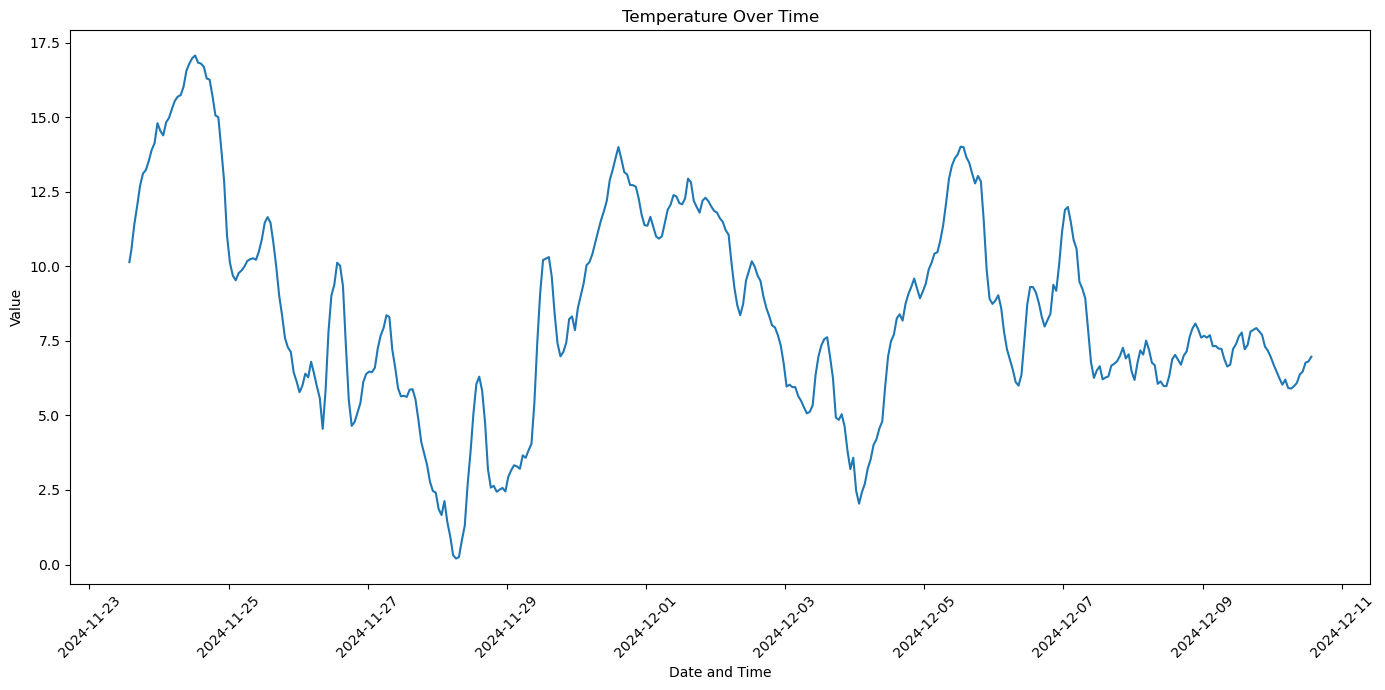

In [1288]:
# Plotting the tempreature over time
plt.figure(figsize=(14, 7))
sns.lineplot(x='datetime', y='temp', data=df_weather)
plt.title('Temperature Over Time')
plt.xlabel('Date and Time')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

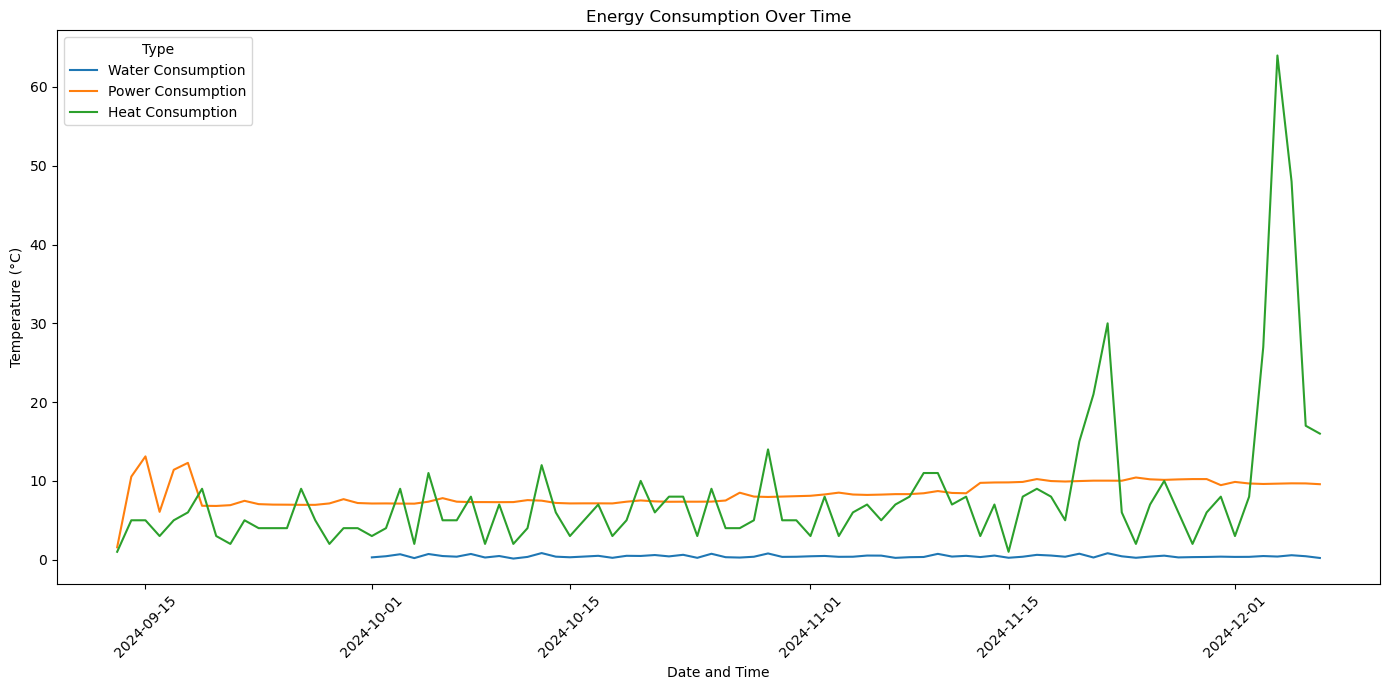

In [1289]:
# Plotting the energy consumption over time
plt.figure(figsize=(14, 7))
sns.lineplot(x='date', y='consumption_water', data=df_water, label='Water Consumption')
sns.lineplot(x='date', y='power_consumption', data=df_power, label='Power Consumption')
sns.lineplot(x='date', y='heat_consumption', data=df_heat, label='Heat Consumption')
plt.title('Energy Consumption Over Time')
plt.xlabel('Date and Time')
plt.ylabel('Temperature (°C)')
plt.legend(title='Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [1291]:
# Stationarity test

numeric_columns = ['temp', 'temp_min', 'temp_max', 'pressure', 'sea_level', 'grnd_level']
df_weather_grouped = df_weather.groupby('date')[numeric_columns].mean().reset_index()
df_heat_grouped = df_heat.groupby('date')['heat_consumption'].sum().reset_index()
df_water_grouped = df_water.groupby('date')['consumption_water'].sum().reset_index()
df_power_grouped = df_power.groupby('date')['power_consumption'].sum().reset_index()


def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out.to_string())
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. The series is stationary.")
    else:
        print("Weak evidence against the null hypothesis, fail to reject the null hypothesis. The series is non-stationary.")
    print('\n')


# Perform ADF test on other relevant columns
adf_test(df_weather_grouped['temp'], 'Temperature')
adf_test(df_water_grouped['consumption_water'], 'Water Consumption')
adf_test(df_power_grouped['power_consumption'], 'Power Consumption')
adf_test(df_heat_grouped['heat_consumption'], 'Heat Consumption')

Augmented Dickey-Fuller Test: Temperature
ADF Test Statistic             -3.306753
p-value                         0.014579
#Lags Used                      2.000000
Number of Observations Used    15.000000
Critical Value (1%)            -3.964443
Critical Value (5%)            -3.084908
Critical Value (10%)           -2.681814
Strong evidence against the null hypothesis, reject the null hypothesis. The series is stationary.


Augmented Dickey-Fuller Test: Water Consumption
ADF Test Statistic            -7.433486e+00
p-value                        6.271124e-11
#Lags Used                     1.000000e+00
Number of Observations Used    6.600000e+01
Critical Value (1%)           -3.533560e+00
Critical Value (5%)           -2.906444e+00
Critical Value (10%)          -2.590724e+00
Strong evidence against the null hypothesis, reject the null hypothesis. The series is stationary.


Augmented Dickey-Fuller Test: Power Consumption
ADF Test Statistic             -1.095516
p-value                 

### Data analysis

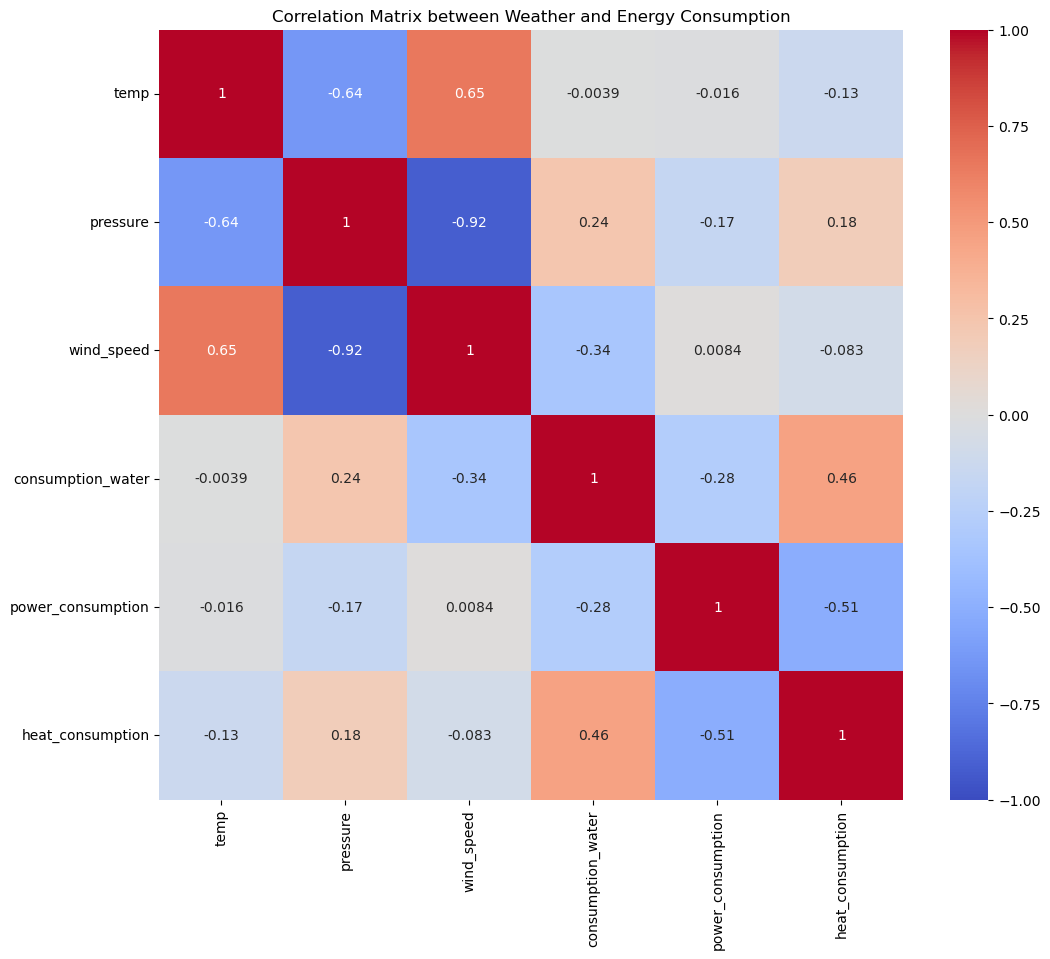

In [1292]:
# Correlation analysis preparation

# Group the weather data by date and calculate the mean for each date
weather_columns = ['temp', 'wind_speed', 'pressure','date', 'humidity']
df_weather_grouped = df_weather[weather_columns].groupby('date').mean().reset_index()

# Merge the data on the date column
merged_df = df_weather_grouped[['date', 'temp', 'wind_speed', 'pressure']].merge(
    df_water[['date', 'consumption_water', 'total_cost']], on='date').rename(columns={'total_cost': 'water_cost'}).merge(
    df_power[['date', 'power_consumption', 'total_cost']], on='date').rename(columns={'total_cost': 'power_cost'}).merge(
    df_heat[['date', 'heat_consumption', 'total_cost']], on='date').rename(columns={'total_cost': 'heat_cost'})


merged_df.dropna(inplace=True)
# Select relevant columns for correlation
correlation_data = merged_df[['temp', 'pressure', 'wind_speed','consumption_water', 'power_consumption', 'heat_consumption']]

# Convert the scaled data back to a DataFrame
correlation_data = pd.DataFrame(correlation_data, columns=['temp', 'pressure', 'wind_speed', 'consumption_water', 'power_consumption', 'heat_consumption'])

# Calculate the correlation matrix
correlation_matrix = correlation_data.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Customize the plot
plt.title('Correlation Matrix between Weather and Energy Consumption')
plt.show()

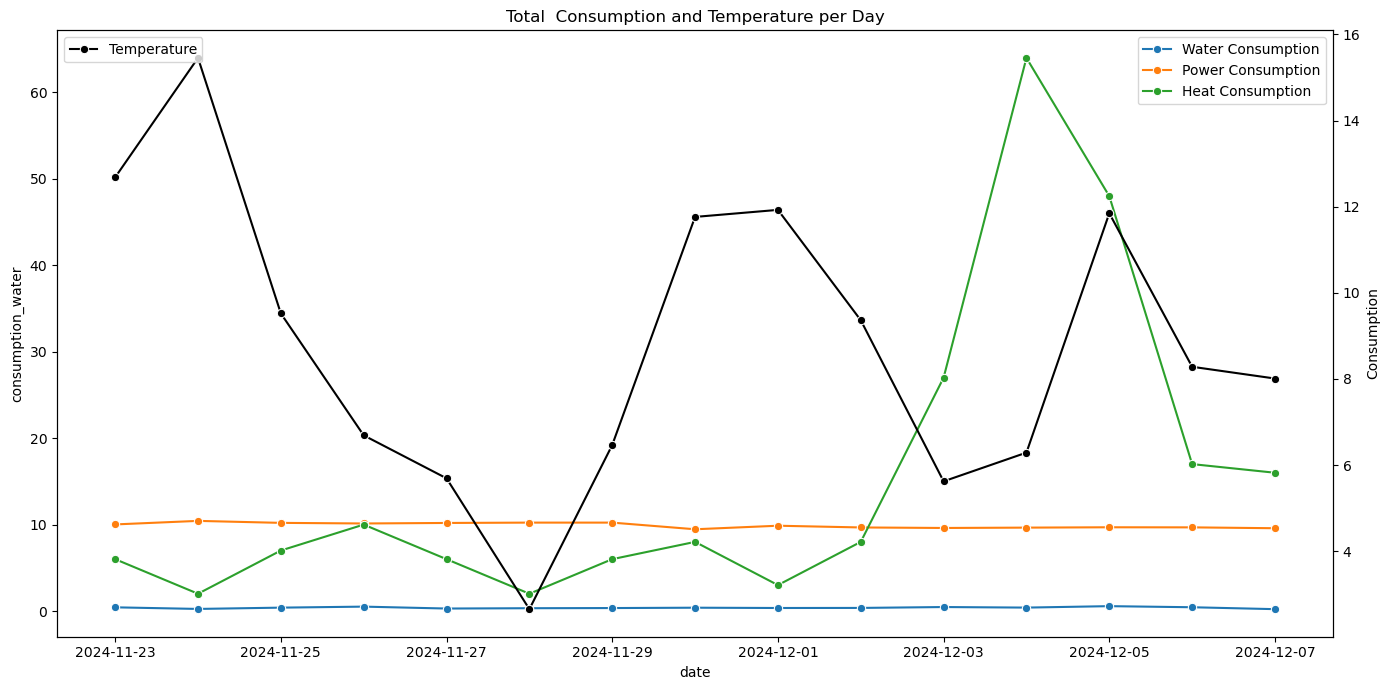

In [1293]:

# Plotting energy correlations 

plt.figure(figsize=(14, 7))

# Plot total cost consumption
sns.lineplot(data=merged_df, x='date', y='consumption_water',  marker='o', label='Water Consumption')
sns.lineplot(data=merged_df, x='date', y='power_consumption',  marker='o', label='Power Consumption')
sns.lineplot(data=merged_df, x='date', y='heat_consumption',  marker='o', label='Heat Consumption')
# Plot temperature on a secondary y-axis
ax2 = plt.gca().twinx()
sns.lineplot(data=merged_df, x='date', y='temp', ax=ax2, color='black', label='Temperature', marker='o')

# Customize the plot
plt.title('Total  Consumption and Temperature per Day')
plt.xlabel('Day')
plt.ylabel('Consumption')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

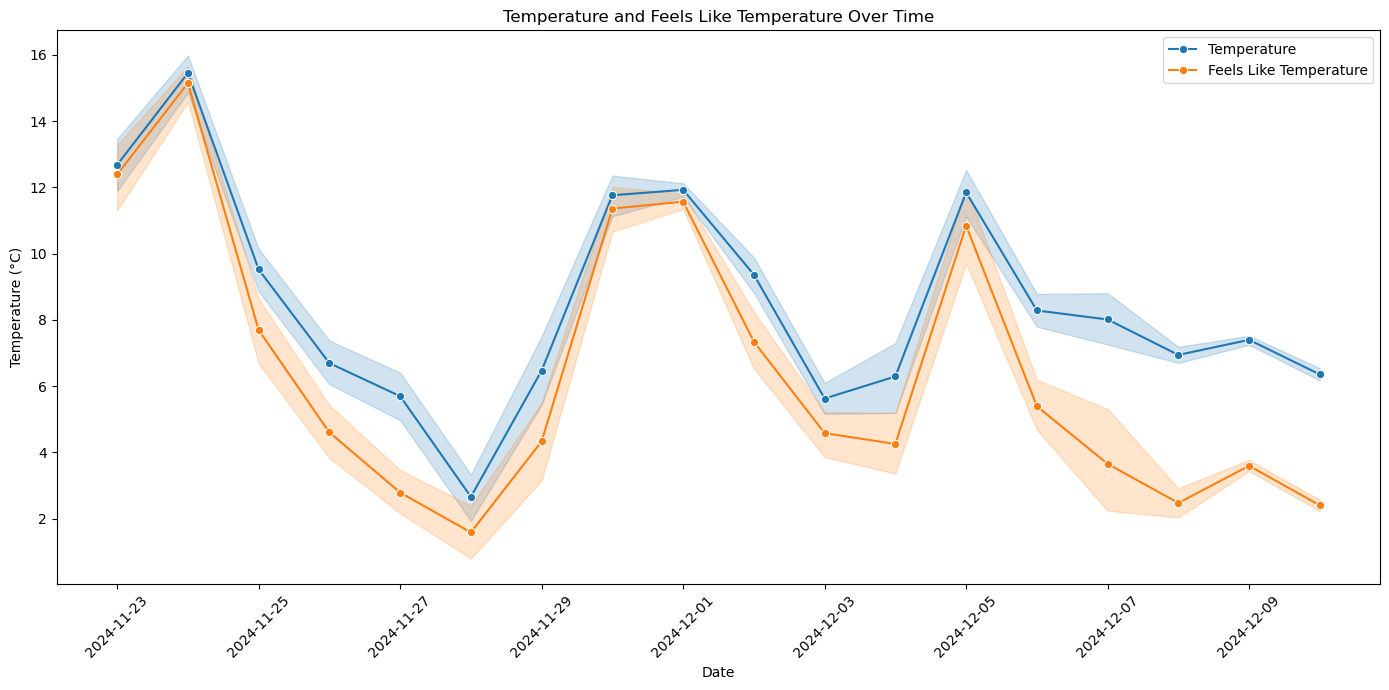

In [1294]:
# Correlation for temperature and feels like temperature
plt.figure(figsize=(14, 7))

# Plot temperature
sns.lineplot(data=df_weather, x='date', y='temp', label='Temperature', marker='o')

# Plot feels like temperature
sns.lineplot(data=df_weather, x='date', y='feels_like', label='Feels Like Temperature', marker='o')

plt.title('Temperature and Feels Like Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()

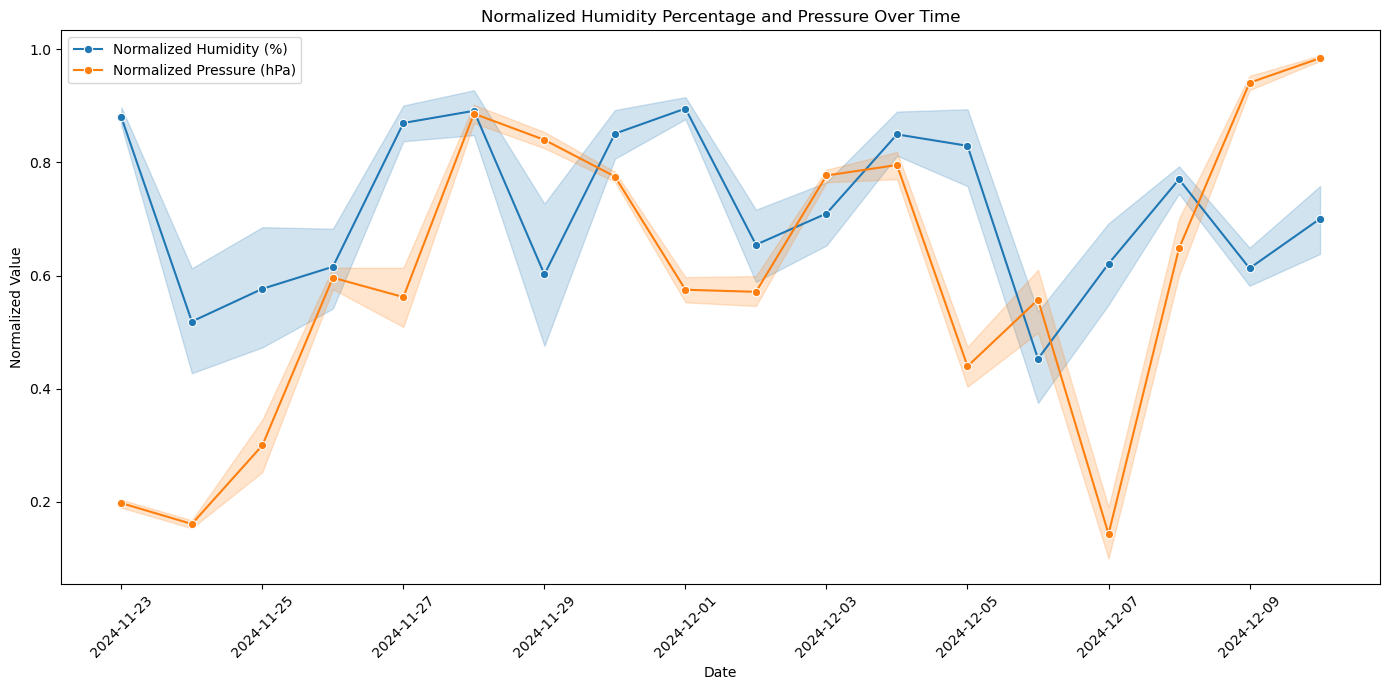

In [1295]:
# Correlation for humidity and pressure

df_weather['humidity_normalized'] = (df_weather['humidity'] - df_weather['humidity'].min()) / (df_weather['humidity'].max() - df_weather['humidity'].min())
df_weather['pressure_normalized'] = (df_weather['pressure'] - df_weather['pressure'].min()) / (df_weather['pressure'].max() - df_weather['pressure'].min())

plt.figure(figsize=(14, 7))

# Plot normalized humidity percentage
sns.lineplot(data=df_weather, x='date', y='humidity_normalized', label='Normalized Humidity (%)', marker='o')

# Plot normalized pressure
sns.lineplot(data=df_weather, x='date', y='pressure_normalized', label='Normalized Pressure (hPa)', marker='o')

plt.title('Normalized Humidity Percentage and Pressure Over Time')
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()

### Weather Status Analysis

In [1296]:
df_weather_analysis = df_weather.copy()

In [1297]:
# Apply textual analysis to the weather values

df_weather_analysis['temp_status'] = df_weather_analysis['temp'].apply(lambda x: "Cold" if x < 10 else "Warm")
df_weather_analysis['feels_like_status'] = df_weather_analysis.apply(
    lambda row: "Feels much colder" if row['feels_like'] < row['temp'] - 4 else "Feels similar", axis=1)
df_weather_analysis['pressure_status'] = df_weather_analysis['pressure'].apply(lambda x: "High pressure" if x > 1018 else "Low pressure")
df_weather_analysis['wind_status'] = df_weather['wind_speed'].apply(
    lambda x: "Low wind" if x < 5 else "Moderate wind" if 5 <= x <= 7.9 else "High wind"
)


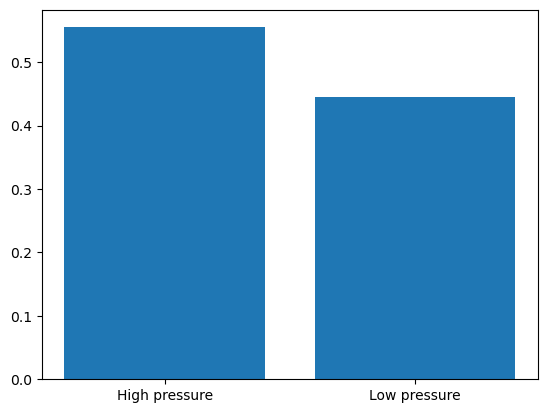

In [1298]:
plt.bar(df_weather_analysis['pressure_status'].unique(),df_weather_analysis['pressure_status'].value_counts(normalize=True).values)
plt.show()

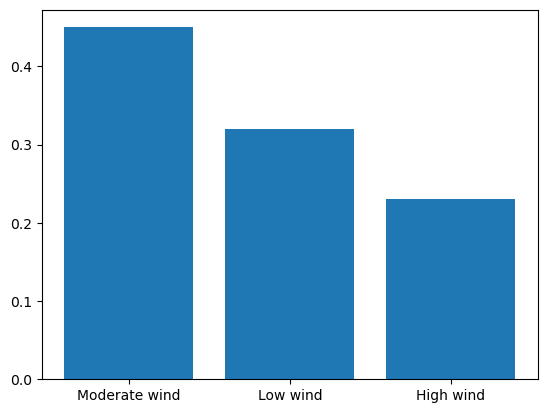

In [1299]:
plt.bar(df_weather_analysis['wind_status'].unique(),df_weather_analysis['wind_status'].value_counts(normalize=True).values)
plt.show()

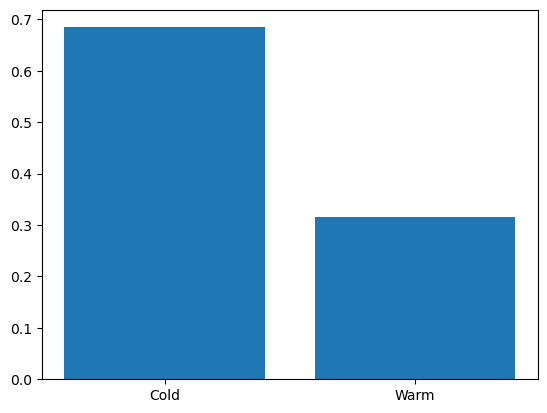

In [1300]:
plt.bar(df_weather_analysis['temp_status'].unique(),df_weather_analysis['temp_status'].value_counts(normalize=True).values)
plt.show()

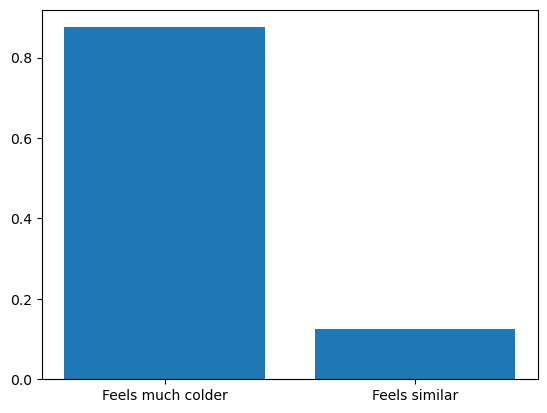

In [1301]:
plt.bar(df_weather_analysis['feels_like_status'].unique(),df_weather_analysis['feels_like_status'].value_counts(normalize=True).values)
plt.show()

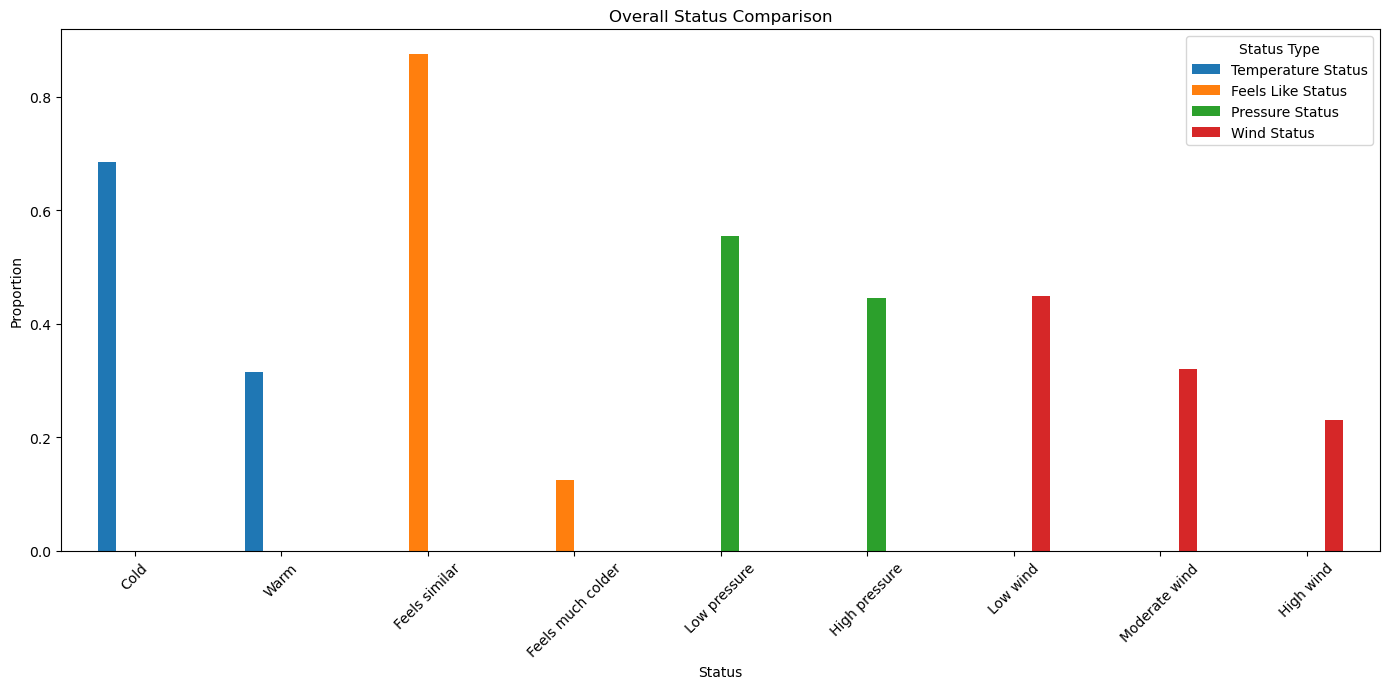

In [1302]:
# overall status comparison

temp_status_counts = df_weather_analysis['temp_status'].value_counts(normalize=True)
feels_like_status_counts = df_weather_analysis['feels_like_status'].value_counts(normalize=True)
pressure_status_counts = df_weather_analysis['pressure_status'].value_counts(normalize=True)
wind_status_counts = df_weather_analysis['wind_status'].value_counts(normalize=True)

# Combine all statuses into a single DataFrame for plotting
status_df = pd.DataFrame({
    'Temperature Status': temp_status_counts,
    'Feels Like Status': feels_like_status_counts,
    'Pressure Status': pressure_status_counts,
    'Wind Status': wind_status_counts
}).fillna(0)

# Sort the DataFrame by the columns to ensure the order is maintained
status_df = status_df.sort_values(['Temperature Status', 'Feels Like Status', 'Pressure Status', 'Wind Status'], ascending=False)

fig, ax = plt.subplots(figsize=(14, 7))
status_df.plot(kind='bar', ax=ax)

# Customize the plot
plt.title('Overall Status Comparison')
plt.xlabel('Status')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend(title='Status Type')
plt.tight_layout()

# Show the plot
plt.show()

### Cost analysis

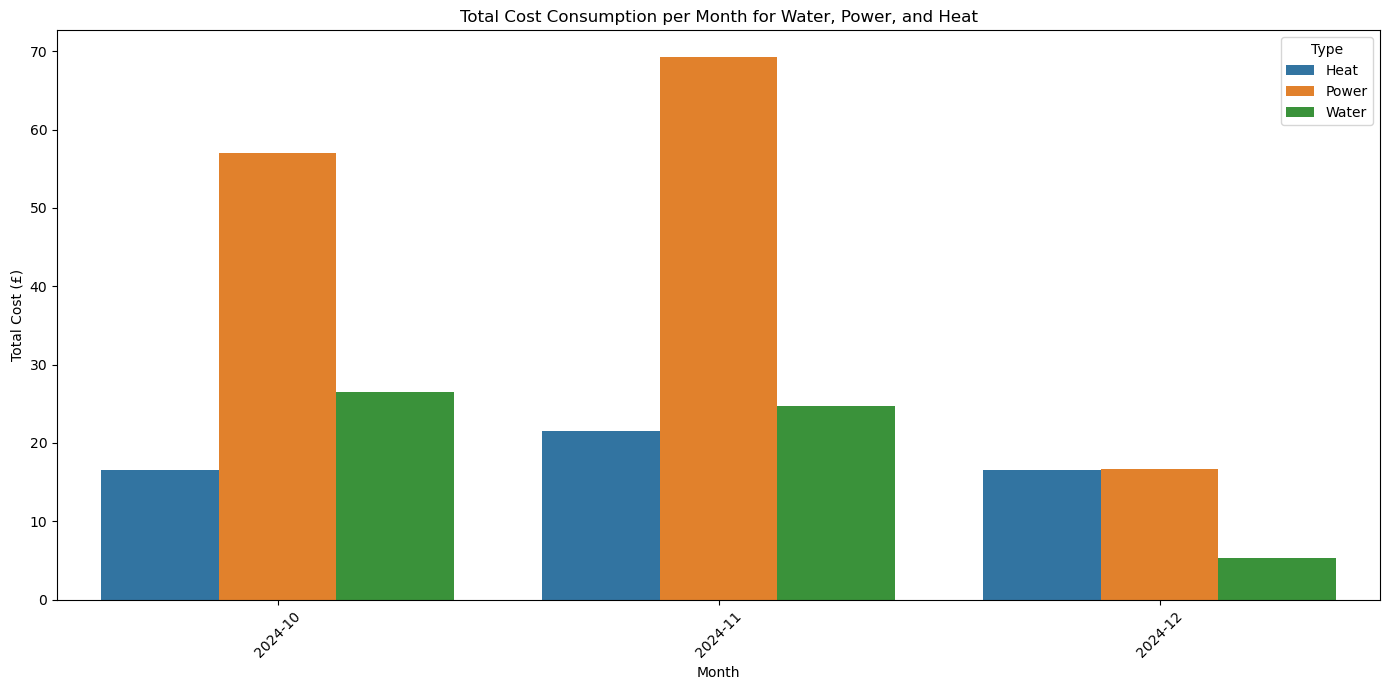

In [1303]:
# Monthly cost consumption

df_water['type'] = 'Water'
df_power['type'] = 'Power'
df_heat['type'] = 'Heat'

# Extract year and month from the date column
df_water['year_month'] = df_water['date'].dt.to_period('M')
df_power['year_month'] = df_power['date'].dt.to_period('M')
df_heat['year_month'] = df_heat['date'].dt.to_period('M')

# Find common months across all DataFrames
common_months = set(df_water['year_month']).intersection(set(df_power['year_month'])).intersection(set(df_heat['year_month']))

# Filter DataFrames to include only the common months
df_water_filtered = df_water[df_water['year_month'].isin(common_months)]
df_power_filtered = df_power[df_power['year_month'].isin(common_months)]
df_heat_filtered = df_heat[df_heat['year_month'].isin(common_months)]

# Combine the total costs into a single DataFrame
combined_df = pd.concat([df_water_filtered[['year_month', 'type', 'total_cost','consumption_water']], df_power_filtered[['year_month', 'type', 'total_cost','power_consumption']], df_heat_filtered[['year_month', 'type', 'total_cost','heat_consumption']]])

# Group by year_month and type, and sum the total costs
monthly_costs = combined_df.groupby(['year_month', 'type'])['total_cost'].sum().reset_index()


plt.figure(figsize=(14, 7))
sns.barplot(data=monthly_costs, x='year_month', y='total_cost', hue='type')

# Customize the plot
plt.title('Total Cost Consumption per Month for Water, Power, and Heat')
plt.xlabel('Month')
plt.ylabel('Total Cost (£)')
plt.xticks(rotation=45)
plt.legend(title='Type')
plt.tight_layout()

# Show the plot
plt.show()

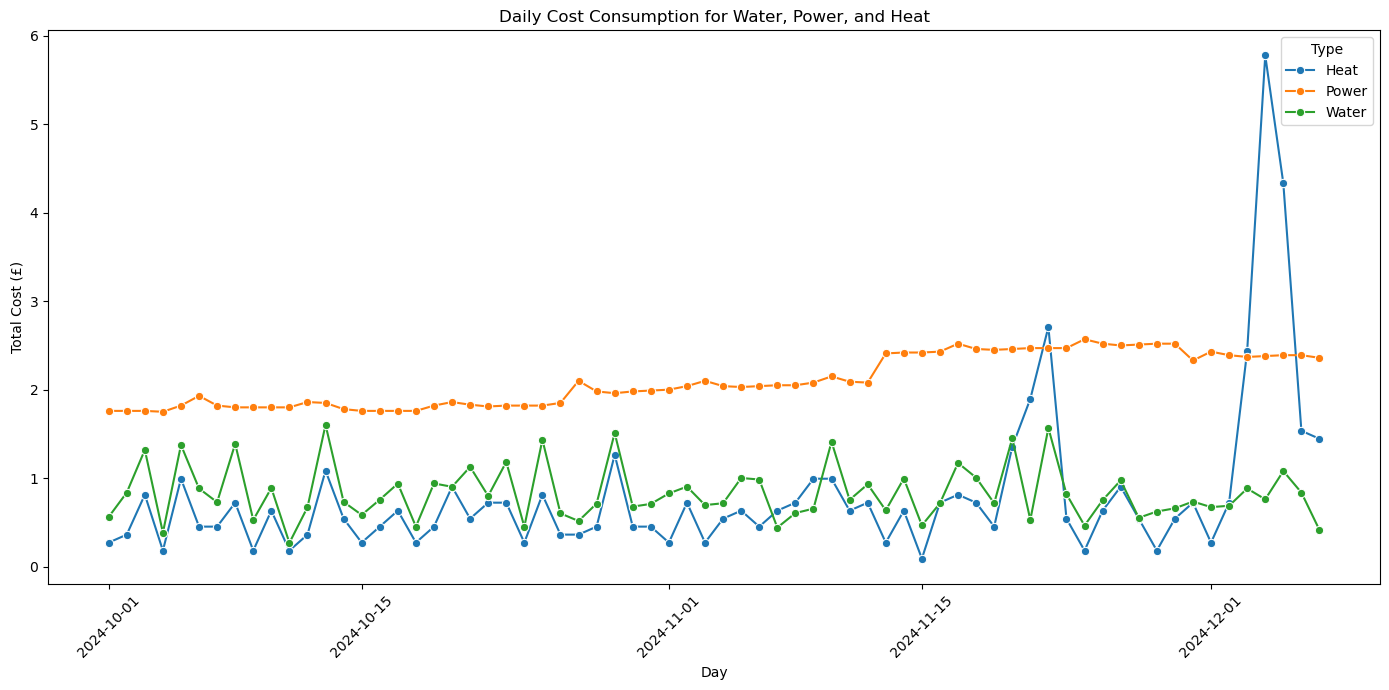

In [1305]:
# Daily cost consumption
daily_df_cost = pd.concat([
    df_water_filtered[['date', 'type', 'total_cost']],
    df_power_filtered[['date', 'type', 'total_cost']],
    df_heat_filtered[['date', 'type', 'total_cost']]
])

# Group by date and type, and sum the total cost
daily_costs = daily_df_cost.groupby(['date', 'type'])['total_cost'].sum().reset_index()

# Plotting
plt.figure(figsize=(14, 7))
sns.lineplot(data=daily_costs, x='date', y='total_cost', hue='type', marker='o')

# Customize the plot
plt.title('Daily Cost Consumption for Water, Power, and Heat')
plt.xlabel('Day')
plt.ylabel('Total Cost (£)')
plt.xticks(rotation=45)
plt.legend(title='Type')
plt.tight_layout()

# Show the plot
plt.show()

### Text analysis for X tweets

In [ ]:
# Sample tweets data

tweets = '/Data/Raw/tweets_sample.rtf'

# Read the tweets from the file
with open(tweets, 'r') as file:
    tweets = file.read()

# Function to clean the tweets
def clean_tweet(tweet):
    # Remove usernames
    tweet = re.sub(r'@\w+', '', tweet)
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    # Remove emojis
    tweet = re.sub(r'[^\x00-\x7F]+', '', tweet)
    # Remove special characters and extra spaces
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    return tweet

# Split the tweets into a list
tweets_list = tweets.split('\n')

# Clean the tweets
cleaned_tweets = [clean_tweet(tweet) for tweet in tweets_list]

/var/folders/sj/twzwp63j52d54yngpp22kfzh0000gn/T/ipykernel_57856/3473921988.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_class', data=df_sentiment, palette='viridis')


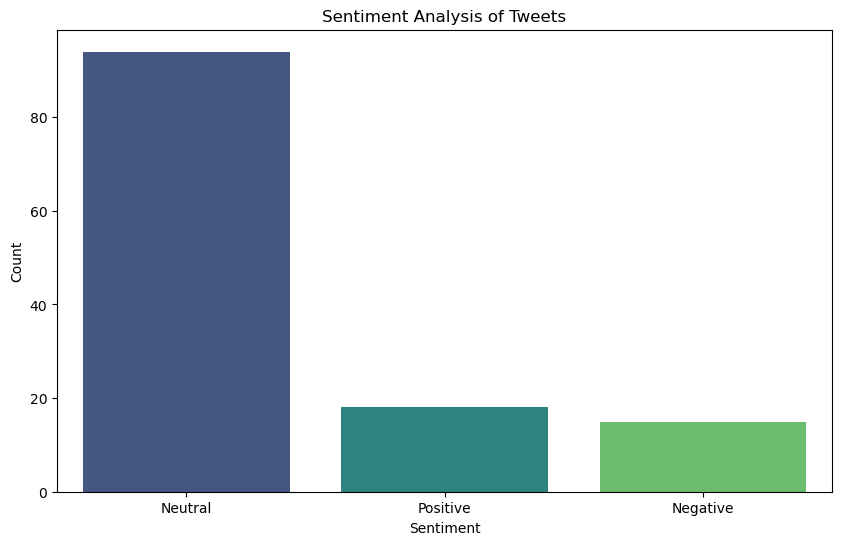

In [1307]:
## Sentiment Analysis

data = {
    'text': cleaned_tweets
}
df_sentiment = pd.DataFrame(data)

# Function to get the sentiment of a tweet
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

df_sentiment['sentiment'] = df_sentiment['text'].apply(get_sentiment)

# Classify the sentiment as positive, negative, or neutral
def classify_sentiment(polarity):
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

df_sentiment['sentiment_class'] = df_sentiment['sentiment'].apply(classify_sentiment)


plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment_class', data=df_sentiment, palette='viridis')
plt.title('Sentiment Analysis of Tweets')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

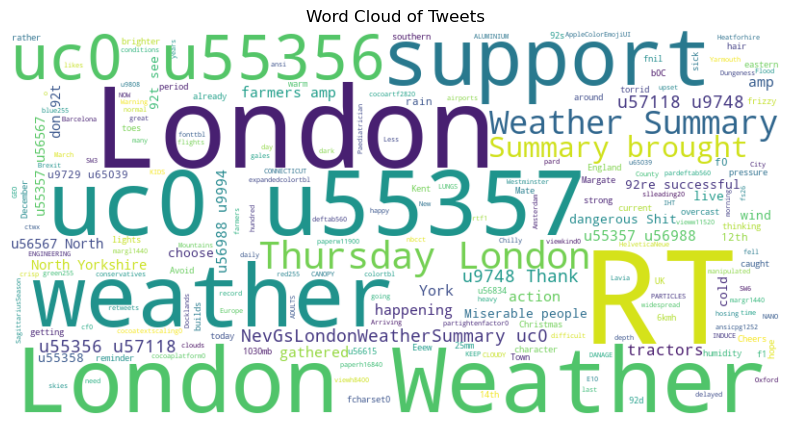

In [1308]:
## Word Cloud

data = {
    'text': cleaned_tweets
}
df_tweets = pd.DataFrame(data)

# Combine all tweets into a single string
all_tweets = ' '.join(df_tweets['text'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_tweets)


words_freq = wordcloud.words_

# Convert the words to a list for exporting

word_freq = pd.DataFrame(words_freq.items(), columns=['word', 'frequency'])

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweets')
plt.show()

### Upload to Google Sheets

In [1309]:
google_links = ['1udYpUBJbxRoPtiy2Vq3yNTD5sOrS20JcMj22uHleM-s',
                '1wt_Bao41GhXl3-TsBdznzWua3qzlCiDkA4hWKjtDR0g',
                '1kcnD4ko5qBS-C9XJS7XK6WWJg2oM6q2-2pWPREC2Ht8',
                '1LK0DbmLUjXftQJmDqndMDogwoxRzCxuLXdQL7OIryEw',
                '1A1a-koc-WZTXwU7rZ47cOjRbZFaUa8F652-qsu37ARk',
                '1eVJX5wkSxsAtP6qwHowBFcJEXUKfkEGBhbqCKtCxxlw']

In [ ]:
scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']

creds = Credentials.from_service_account_file('/cred/iot-project-444518-2dd35faffe54.json', scopes=scope)
client = gspread.authorize(creds)

# Function to upload CSV to Google Sheets
def upload_csv_to_gsheets(csv_path, sheet_name):
    # Read the CSV file
    df = pd.read_csv(csv_path)
    
    # Replace NaN values with an empty string
    df.fillna('', inplace=True)
    
    # Create a new Google Sheet
    sheet = client.create(sheet_name)
    
    # Share the sheet with the public
    sheet.share('', perm_type='anyone', role='reader')
    
    # Select the first sheet
    worksheet = sheet.get_worksheet(0)
    
    # Clear the sheet
    worksheet.clear()
    
    # Set the sheet headers
    worksheet.update([df.columns.values.tolist()] + df.values.tolist())
    
    # Get the public URL
    public_url = f"https://docs.google.com/spreadsheets/d/{sheet.id}/edit?usp=sharing"
    return public_url

#  Upload CSV files to Google Sheets
final_tweets_url = upload_csv_to_gsheets('/Data/processed/agg_energy_data.csv', 'Aggregated Energy Data')
merged_df_url = upload_csv_to_gsheets('/Data/processed/word_freq.csv', 'Tweets Data')
combined_df_url = upload_csv_to_gsheets('/Data/processed/consumptions.csv', 'Consumptions')
daily_costs_url = upload_csv_to_gsheets('/Data/processed/daily_costs.csv', 'Daily Costs')
monthly_costs_url = upload_csv_to_gsheets('/Data/processed/monthly_costs.csv', 'Monthly Costs')
df_weather_analysis_url = upload_csv_to_gsheets('/Data/processed/df_weather_analysis.csv', 'Weather Analysis')
df_sentiment_analysis_url = upload_csv_to_gsheets('/Data/processed/sentiment.csv', 'Sentiment Analysis')

# Print the public URLs
print("Final Tweets URL:", final_tweets_url)
print("Merged Data URL:", merged_df_url)
print("Consumptions URL:", combined_df_url)
print("Daily Costs URL:", daily_costs_url)
print("Monthly Costs URL:", monthly_costs_url)
print("Weather Analysis URL:", df_weather_analysis_url)
print("Sentiment Analysis URL:", df_sentiment_analysis_url)

/var/folders/sj/twzwp63j52d54yngpp22kfzh0000gn/T/ipykernel_57856/4026830199.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna('', inplace=True)


Final Tweets URL: https://docs.google.com/spreadsheets/d/1IK1jDpXTh6jSAEeJZh1Cd8Dur9anFWrXGT54Bfka3sQ/edit?usp=sharing
Merged Data URL: https://docs.google.com/spreadsheets/d/1m0N8mUU_PAP6cEE2RIYnVM7GbE3On0CHJo8UyrucfVE/edit?usp=sharing
Consumptions URL: https://docs.google.com/spreadsheets/d/1CcgVrS0yzZCigbeJcT1bTZAiL1Cpgx-VbB58WgM2UU8/edit?usp=sharing
Daily Costs URL: https://docs.google.com/spreadsheets/d/1aRtBLEq1Fs7UknYHJ0NOyUtXYw725bJ52k9D3_0QXnM/edit?usp=sharing
Monthly Costs URL: https://docs.google.com/spreadsheets/d/19E_RcryFjxqK3eA9PXMdErOeuFFV8pj-V1TiOMK-Qec/edit?usp=sharing
Weather Analysis URL: https://docs.google.com/spreadsheets/d/1f3ijEXeULuSgIqKbOWtPgrFOePSxWXtJ6Om4VzCO5sA/edit?usp=sharing


### End of report